In [36]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import scikit_posthocs as sp
from Bio.SeqUtils import GC
import numpy as np
from collections import Counter, OrderedDict
from os import listdir

In [37]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

### Import list of all experiments

In [38]:
path='C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\04_Lukas_Schmidheini\\Nuclease\\BE_Library_Nuclease\\AnalysisFiles\\'

def list_files1(directory):
    return [f for f in listdir(directory) if 'LS' in f]

sampledf = pd.DataFrame(columns=['filename','Editor','Replicate'])
filelist = list_files1(path)
sampledf['filename'] = filelist
sampledf['Library'] = 'BE_Library'
sampledf['Editor'] = sampledf['filename'].apply(lambda x: x.split('_')[2])
sampledf['Replicate'] = sampledf['filename'].apply(lambda x: x.split('_')[-1][3:4])
sampledf['Control'] = sampledf['filename'].apply(lambda x: True if 'control' in x else False)
sampledf['repname'] = sampledf.apply(lambda x: x.Editor+"_"+x.Replicate,axis=1)
#sampledf['Cell_line_Editor'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor,axis=1)
#sampledf['repname'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor+"_"+x.Replicate,axis=1)

In [39]:
templatedf = pd.read_csv('C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\04_Lukas_Schmidheini\\Nuclease\\BE_Library_Nuclease\\20220228_Library_March_combined_LS.csv')

In [40]:
sampledf

,filename,Editor,Replicate,Library,Control,repname
0,20221004_LS_control_rep1.csv,control,1,BE_Library,True,control_1
1,20221004_LS_control_rep2.csv,control,2,BE_Library,True,control_2
2,20221004_LS_control_rep3.csv,control,3,BE_Library,True,control_3
3,20221004_LS_p551evo_rep1.csv,p551evo,1,BE_Library,False,p551evo_1
4,20221004_LS_p551evo_rep2.csv,p551evo,2,BE_Library,False,p551evo_2
5,20221004_LS_p551evo_rep3.csv,p551evo,3,BE_Library,False,p551evo_3
6,20221004_LS_p551wlt_rep1.csv,p551wlt,1,BE_Library,False,p551wlt_1
7,20221004_LS_p551wlt_rep2.csv,p551wlt,2,BE_Library,False,p551wlt_2
8,20221004_LS_p551wlt_rep3.csv,p551wlt,3,BE_Library,False,p551wlt_3


### Calculate control characteristics for each experimental setup

In [41]:
dataframe = pd.read_csv(path+'20221004_LS_p551evo_rep1.csv')
dataframe

,Unnamed: 0,Unnamed: 0.1,Name,Gene,Phenotype,PAM,ABE pos,CBE pos,Sequence,Reverse-Complement,...,FinalLibrary 01.03.2022,Unnamed: 23,spacer_part,Spacer_Length,target,Barcode,uneditedcount,indelcount,totalreads,variantindex
0,0,146.0,NM_007375.3(TARDBP):c.1042G>T (p.Gly348Cys),TARDBP,Amyotrophic lateral sclerosis type 10;not prov...,TAAC,NaN,NaN,GGGTATGATGGGCATGTTAGCCAGCCAGCAGAACCAGTCAGGCCCA...,CTCTGCATGTTGCCTTGGTTTTGGTTATTACCCGATGGGCCTGACT...,...,GTGGAAAGGACGAAACACCGCAGAACCAGTCATGCCCATCGGGTTC...,NaN,GCAGAAC,23,TCATGCCCATCGGGTAATAA,TATGTG,8,464,472.0,0
1,1,161.0,NM_004958.4(MTOR):c.6625C>G (p.Leu2209Val),MTOR,Metastatic pancreatic neuroendocrine tumours,TAAC,NaN,NaN,TACCTGAGGTTTTTCCGAAGAGATGTTGGGTCATTGGCCAGAAGGG...,TGAGCGTGTGATGCAGCTCTTCGGCCTGGTTAACACCCTTCTGGCC...,...,GTGGAAAGGACGAAACACCGTGTTGGGTCATTGGCCACAAGGGTTC...,NaN,GTGTTGG,23,ATTGGCCACAAGGGTGTTAA,ACGTGC,147,348,495.0,1
2,2,200.0,NM_005957.4(MTHFR):c.604C>A (p.Pro202Thr),MTHFR,Homocysteinemia due to MTHFR deficiency,TAAC,NaN,NaN,TTCAAGTGCTTCAGGTCAGCCTCAAAGCTCCCTGCTTCGGGGTGGC...,CTGACTGTCATCCCTATTGGCAGGTTACCCCAAAGGCCACCCCGAA...,...,GTGGAAAGGACGAAACACCGTCCCTGCTTCGGTGTGGCCTTTGTTC...,NaN,GTCCCTG,23,CGGTGTGGCCTTTGGGGTAA,AATCGA,852,609,1461.0,2
3,3,248.0,NM_014874.3(MFN2):c.703C>T (p.Gln235Ter),MFN2,"Charcot-Marie-Tooth disease, type 2",TAAC,NaN,NaN,TGTGTTTGTGCTGGTGGCCAACTCAGAGTCCACCCTGATGCAGACG...,GCTGGGAGCTTGGGAGAAGGCAGAGGAGGAGTTACCGTCTGCATCA...,...,GTGGAAAGGACGAAACACCGCTCAGAGTCCACCCTGATGTAGGTTC...,NaN,GCTCAGA,23,CACCCTGATGTAGACGGTAA,CGGATA,287,538,825.0,3
4,4,347.0,NM_003000.2(SDHB):c.287-1G>C,SDHB,Gastrointestinal stroma tumor;Hereditary Parag...,TAAC,NaN,NaN,TTGCCTCCATTGATGTTCATTGCACAAGAGCCACAGATGCCTGAAA...,CGGATATGGGTGAGGATGTGTTAAATGTGTGTCTCTTTCAGGCATC...,...,GTGGAAAGGACGAAACACCGACAGATGCGTGAAAGAGACACAGTTC...,NaN,GACAGAT,23,TGAAAGAGACACACATTTAA,TCATTA,2135,372,2507.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,NaN,Eif2b5_2,Eif2b5,NaN,various,13.0,NaN,NaN,NaN,...,GTGGAAAGGACGAAACACCGAGCCACCCTACACACTGCCATGGTTC...,NaN,GAGCCAC,23,ACACACTGCCATGAGGACAA,GGGAAT,222,693,915.0,495
496,496,387.0,V0_scaffold_NM_003748.4(ALDH4A1):c.1055C>T (p....,ALDH4A1,Deficiency of pyrroline-5-carboxylate reductase,ACAC,NaN,NaN,TTTGATCTGCGGCCACAGCGAGTGCGGCACGTAGAGACGCGAGCAC...,TCAGCCTTCGAGTACGGTGGCCAGAAGTGTTCCGCGTGCTCGCGTC...,...,GTGGAAAGGACGAAACACCGGCACGTAGAGACGCAAGCACGGTTTT...,NaN,GGCACGT,22,AGACGCAAGCACGCGGAACA,GTGCTA,4,341,345.0,496
497,497,NaN,V2_scaffold_NM_003748.4(ALDH4A1):c.1055C>T (p....,ALDH4A1,Deficiency of pyrroline-5-carboxylate reductase,ACAC,NaN,NaN,NaN,NaN,...,GTGGAAAGGACGAAACACCGGCACGTAGAGACGCAAGCACGGCTTT...,NaN,GGCACGT,22,AGACGCAAGCACGCGGAACA,ATCGGC,13,1093,1106.0,497
498,498,NaN,V3_scaffold_NM_003748.4(ALDH4A1):c.1055C>T (p....,ALDH4A1,Deficiency of pyrroline-5-carboxylate reductase,ACAC,NaN,NaN,NaN,NaN,...,GTGGAAAGGACGAAACACCGGCACGTAGAGACGCAAGCACGGTCTT...,NaN,GGCACGT,22,AGACGCAAGCACGCGGAACA,GCCACA,1,346,347.0,498


In [42]:
ctrllist = sampledf[sampledf['Editor'] == 'control']
ctrldf = templatedf.copy()
for index, row in ctrllist.iterrows():
    controlrepdf = pd.read_csv(path+row.filename)
    ctrldf[row.repname+'_totalreads'] = controlrepdf['totalreads']
    controlrepdf['percentageindel'] = controlrepdf.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
    controlrepdf['percentageunedited'] = controlrepdf.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
    ctrldf[row.repname+'_percentageunedited'] = controlrepdf['percentageunedited']
    ctrldf[row.repname+'_percentageindel'] = controlrepdf['percentageindel']
    ctrldf[row.repname+'_uneditedcount'] = controlrepdf['uneditedcount']
    ctrldf[row.repname+'_indelcount'] = controlrepdf['indelcount']

for index, row in ctrllist.iterrows():    
    ctrldf = ctrldf[ctrldf[row.repname+'_totalreads'] > 100]
    ctrldf = ctrldf[ctrldf[row.repname+'_percentageindel'] < 30]

In [43]:
editorlist = sampledf['Editor'].unique()
editorlist = [x for x in editorlist if not 'control' in x]
experimentdict = {}
for editor in editorlist:
    experimentdf = templatedf.copy()
    for index, row in sampledf[sampledf['Editor'] == editor].iterrows():
        dataframe = pd.read_csv(path+row.filename)
        dataframename = row.Editor+"_"+row.Replicate
        experimentdf[dataframename+'_totalreads'] = dataframe['totalreads']
        dataframe['percentageindel'] = dataframe.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
        dataframe['percentageunedited'] = dataframe.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
        experimentdf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
        experimentdf[dataframename+'_percentageindel'] = dataframe['percentageindel']
        experimentdf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
        experimentdf[dataframename+'_indelcount'] = dataframe['indelcount']
    replicates = list(sampledf[sampledf['Editor'] == editor].repname)
    controldf = sampledf[(sampledf['Editor'] == 'ctr')]
    #controlname = controldf['Cell_line_Editor'] + '_' + controldf['Replicate']
    
    ctrluneditedlist = []
    ctrlindellist = []
    lib = "BE_Library"
    for index, row in ctrllist.iterrows():
        ctrluneditedlist.append(row.repname+'_percentageunedited')
        ctrlindellist.append(row.repname+'_percentageindel')
        
    experimentdf[lib+'_ctr'+'_percentageunedited'] = ctrldf[ctrluneditedlist].mean(axis=1)
    experimentdf[lib+'_ctr'+'_percentageindel'] = ctrldf[ctrlindellist].mean(axis=1)
    #print()
    #print(controlname)
    #print(cellline)
    cutoff = 100
    initialtemplen = len(experimentdf)
    #print('Total variants:',initialtemplen)
    for replicate in replicates:
        experimentdf = experimentdf[experimentdf[replicate+'_totalreads']>cutoff]

    experimentdict[editor] = experimentdf

### Calculate editing characteristics for all experimental setups
Also clip editing levels to be between 0-100.

In [44]:
sampledf_woctr = sampledf[sampledf['Editor'] != 'control']

In [45]:
editordf = sampledf_woctr.copy()
editordf = editordf[editordf['Replicate'] == "1"]
editordf = editordf.set_index('Editor')
editordf['Editor'] = editordf.index
cols = ['Library','Editor']
editordf = editordf[cols]
editordf

,Library,Editor
Editor,,
p551evo,BE_Library,p551evo
p551wlt,BE_Library,p551wlt


In [46]:
for editor in experimentdict:
    print(editor)
    replicatelist = list(sampledf_woctr[sampledf_woctr['Editor'] == editor]['repname'])
    ctrname = lib+'_ctr'
    
    for replicate in replicatelist:
        print(replicate)
        repnr = replicate.split('_')[-1]
        experimentdict[editor][replicate+'_percentageindel_corrected_individual'] = experimentdict[editor].apply(lambda x: ((x[replicate+'_percentageindel']-x[ctrname+'_percentageindel'])/((100-x[ctrname+'_percentageindel'])/100)),axis=1)
        editordf.at[editor,repnr +'_meanindel'] = None
        editordf.at[editor,repnr +'_meanindel'] = experimentdict[editor][[replicate +'_percentageindel_corrected_individual']].mean()
        
    allreps = []
    for index,row in sampledf_woctr[sampledf_woctr['Editor'] == editor].iterrows():
        rep = row.Editor+'_'+row.Replicate
        allreps.append(rep)
        
    print(allreps)    
    experimentdict[editor][editor+'_averageindel'] = experimentdict[editor][[x +'_percentageindel_corrected_individual' for x in allreps]].mean(axis=1)
    
       
    # Clip editing rates to be between 0 and 100
    experimentdict[editor][editor+'_averageindel'] = experimentdict[editor][editor+'_averageindel'].clip(0,100)
    
    experimentdict[editor] = experimentdict[editor].dropna(subset=[editor+'_averageindel'])
    
    replist = ['1_meanindel','2_meanindel','3_meanindel']
    
    
    
    
    editordf.at[editor,'numberofvariants'] = len(experimentdict[editor])
    editordf.at[editor,'meanindel'] = experimentdict[editor][editor+'_averageindel'].mean()
    editordf.at[editor,'standarddeviation'] = experimentdict[editor][editor+'_averageindel'].std()
    experimentdict[editor].to_csv('.//BE_Library_Nuclease//AnalysisFiles//summary//20221004_'+editor+'_analysis_dataframe.csv')

p551evo
p551evo_1
p551evo_2
p551evo_3
['p551evo_1', 'p551evo_2', 'p551evo_3']
p551wlt
p551wlt_1
p551wlt_2
p551wlt_3
['p551wlt_1', 'p551wlt_2', 'p551wlt_3']


In [47]:
for index, row in editordf.iterrows():
    editordf.at[index,'replicate_meanindel'] = (row['1_meanindel'] + row['2_meanindel'] + row['3_meanindel']) / 3
    editordf.at[index,'replicate_std'] = np.std([row['1_meanindel'],row['2_meanindel'],row['3_meanindel']])

In [48]:
editordf['filename'] = editordf.apply(lambda x: '20220912_'+x.Editor+'_analysis_dataframe.csv',axis=1)
editordf.to_csv('.//BE_Library_Nuclease//AnalysisFiles//summary//20221004_BE_Library_Nuclease_summary_mean_std.csv')
editordf

,Library,Editor,1_meanindel,2_meanindel,3_meanindel,numberofvariants,meanindel,standarddeviation,replicate_meanindel,replicate_std,filename
Editor,,,,,,,,,,,
p551evo,BE_Library,p551evo,48.642795,48.644830,47.218908,375.0,48.209533,26.977138,48.168844,0.671707,20220912_p551evo_analysis_dataframe.csv
p551wlt,BE_Library,p551wlt,22.937605,10.967847,10.573437,370.0,14.957036,16.610515,14.826296,5.737821,20220912_p551wlt_analysis_dataframe.csv


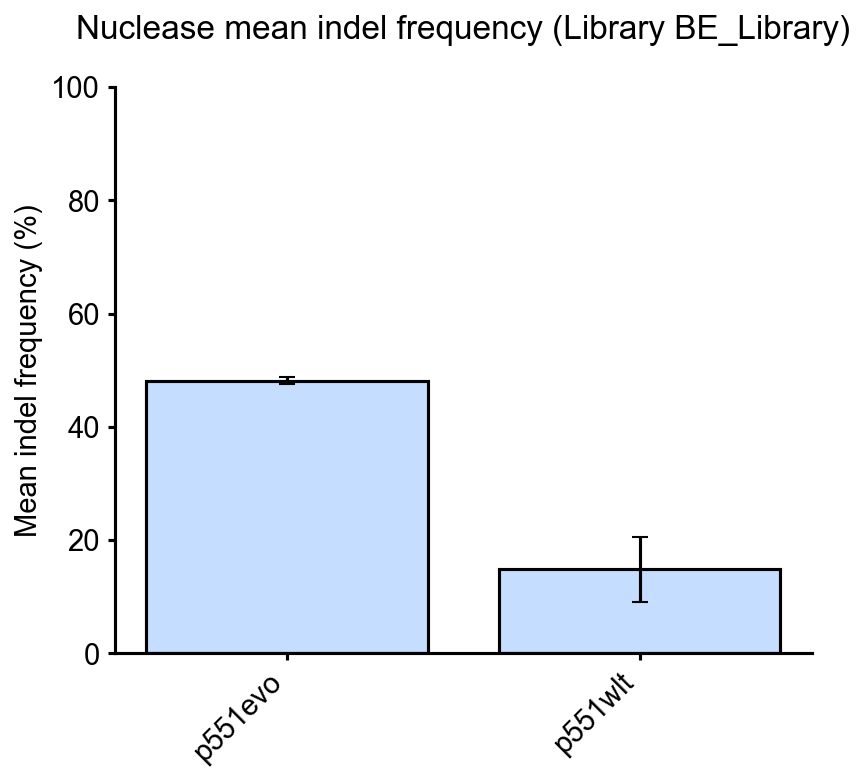

In [49]:
conditionlist = list(editordf.index)
meanlist = list(editordf.replicate_meanindel)
stdlist = list(editordf.replicate_std)

fig1, ax1 = plt.subplots(figsize = (6,5),dpi=150,sharex=True)
ax1.set_title('Nuclease mean indel frequency (Library BE_Library)\n', fontsize=titlesize)
ax1.bar(conditionlist,meanlist,yerr=stdlist, **bar_kwargs)
ax1.set_xticks(range(len(conditionlist)))
ax1.set_xticklabels(conditionlist, ha="right")
#ax1.set_yticks(np.linspace(0,1,11))
ax1.set_ylabel('Mean indel frequency (%)', fontsize=lsize)
ax1.tick_params(axis='x', labelsize= lsize, width=1.5, rotation=45)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
ax1.set_ylim(0,100)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\04_Lukas_Schmidheini\\Nuclease\\BE_Library_Nuclease\\'
#plt.savefig(figurepath+'Nuclease_BE_Library_Nuclease_meanefficiency.pdf', format='pdf',
#        transparent=True,bbox_inches='tight')